# Sentiment Analysis
Sentiment Analysis or Opinion Mining refers to the use of NLP, text analysis and computational linguistics to determine subjective information or the emotional state of the writer/subject/topic. It is commonly used in reviews which save businesses a lot of time from manually reading comments.

In [1]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Updating Vader Lexicon with External Lexicon

In [2]:
import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('lexicon_data/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' ')) == 1}
stock_lex_scaled = {}
for k,v in stock_lex.items():
    if v>0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4
        
# loughran and MacDonald
positive = []
with open('lexicon_data/lm_positive.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        positive.append(row[0].strip())
        
negative = []
with open('lexicon_data/lm_negative.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        entry = row[0].strip().split(" ")
        if len(entry) > 1:
            negative.extend(entry)
        else:
            negative.extend(entry[0])
            
final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Scraping FB posts from Business Times

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

date_sentiments = {}

for i in range(1,11):
    page = urlopen('https://www.businesstimes.com.sg/search/facebook?page='+str(i)).read()
    soup = BeautifulSoup(page, features="html.parser")
    posts = soup.findAll("div", {"class": "media-body"})
    for post in posts:
        time.sleep(1)
        url = post.a['href']
        date = post.time.text
        print(date, url)
        try:
            link_page = urlopen(url).read()
        except:
            url = url[:-2]
            link_page = urlopen(url).read()
        link_soup = BeautifulSoup(link_page)
        sentences = link_soup.findAll("p")
        passage = ""
        for sentence in sentences:
            passage += sentence.text
        sentiment = sia.polarity_scores(passage)['compound'] # the compound score is a normalized score of sum_s and
        # sum_s is the sum of valence computed based on some heuristics and a sentiment lexicon (aka. Sentiment Intensity) and
        # the normalized score is simply the sum_s divided by its square plus an alpha parameter that increases the denominator of the normalization function.
        date_sentiments.setdefault(date, []).append(sentiment)

date_sentiment = {}

for k,v in date_sentiments.items():
    date_sentiment[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3)

earliest_date = min(date_sentiment.keys())

print(date_sentiment)

10 Jan 2020 https://www.businesstimes.com.sg/technology/lawmakers-facebooks-steps-to-tackle-deepfake-videos-inadequate
08 Jan 2020 https://www.businesstimes.com.sg/consumer/facebooks-new-singapore-team-to-serve-china-advertising-business
08 Jan 2020 https://www.businesstimes.com.sg/technology/facebook-tightening-policy-against-deepfakes
07 Jan 2020 https://www.businesstimes.com.sg/government-economy/trump-says-zuckerberg-told-him-hes-facebooks-number-one
28 Dec 2019 https://www.businesstimes.com.sg/banking-finance/facebooks-libra-has-failed-in-current-form-says-swiss-president
23 Dec 2019 https://www.businesstimes.com.sg/technology/data-on-more-than-250m-us-facebook-users-exposed-online
21 Dec 2019 https://www.businesstimes.com.sg/technology/twitter-facebook-target-state-linked-accounts-made-to-manipulate
20 Dec 2019 https://www.businesstimes.com.sg/garage/facebook-buys-startup-to-build-live-shopping-feature-source
20 Dec 2019 https://www.businesstimes.com.sg/technology/facebook-says-i

04 Oct 2019 https://www.businesstimes.com.sg/technology/us-allies-urge-facebook-not-to-encrypt-messages-as-they-fight-child-abuse-terrorism
03 Oct 2019 https://www.businesstimes.com.sg/technology/facebook-may-have-to-censor-online-hate-globally-eu-judges-say
02 Oct 2019 https://www.businesstimes.com.sg/technology/facebook-to-pay-subset-of-news-tab-publishers
01 Oct 2019 https://www.businesstimes.com.sg/technology/ahead-of-2020-facebook-falls-short-on-plan-to-share-data-on-disinformation
30 Sep 2019 https://www.businesstimes.com.sg/banking-finance/regulatory-concerns-may-delay-launch-of-facebooks-libra-exec
30 Sep 2019 https://www.businesstimes.com.sg/technology/facebook-whatsapp-will-have-to-share-messages-with-uk-police
27 Sep 2019 https://www.businesstimes.com.sg/technology/facebook-tests-hiding-likes-on-social-media-posts
26 Sep 2019 https://www.businesstimes.com.sg/technology/facebook-unveils-virtual-social-space-for-its-oculus-users
24 Sep 2019 https://www.businesstimes.com.sg/tec

In [4]:
from __future__ import (absolute_import, division, print_function,unicode_literals)

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotmargin = 0.15,
        plothlines = [0],
        plotyticks = [1.0, 0, -1.0]
    )
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment
        
class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        # Buy/Sell order submitted/accepted to/by broker -> nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return 
        
        # Check if an order has been completed
        # Broker can reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f'%
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))
                self.bar_executed = len(self)
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        # No pending order
        self.order = None
            
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f'%(trade.pnl, trade.pnlcomm))
        
    # Main strat    
    def next(self):
        # log close price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # check if an order is pending, if yes, we can't send a 2nd one
        if self.order:
            return
        print("Sentiment Score",self.sentiment)
        if not self.position and prev_sentiment:
            # buy 10 shares of its stock if the sentiment increases by 0.5 AND currenct close more than sma
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('BUY CREATE, %.2f'% self.dataclose[0])
                self.order = self.buy()
                    
        elif prev_sentiment:
            # or sell if it decreases by 0.5 AND currenct close less than sma
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f'% self.dataclose[0])
                self.order = self.sell()
                    
    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
             (self.params.period, self.broker.getvalue()), doprint=True)
        

Starting Portfolio Value: 100000.00
2019-09-20, Close, 189.93
Sentiment Score None
2019-09-23, Close, 186.82
Sentiment Score None
2019-09-24, Close, 181.28
Sentiment Score 0.994
2019-09-25, Close, 182.80
Sentiment Score 0.994
2019-09-26, Close, 180.11
Sentiment Score 0.994
2019-09-27, Close, 177.10
Sentiment Score 0.984
2019-09-30, Close, 178.08
Sentiment Score 0.984
2019-10-01, Close, 175.81
Sentiment Score 0.623
2019-10-02, Close, 174.60
Sentiment Score 0.996
2019-10-03, Close, 179.38
Sentiment Score 0.99
2019-10-04, Close, 180.45
Sentiment Score -0.871
2019-10-07, Close, 179.68
Sentiment Score -0.871
2019-10-08, Close, 177.75
Sentiment Score 0.992
2019-10-09, Close, 179.85
Sentiment Score 0.992
2019-10-10, Close, 180.03
Sentiment Score 0.984
2019-10-11, Close, 184.19
Sentiment Score 0.999
2019-10-14, Close, 183.28
Sentiment Score 0.999
2019-10-15, Close, 188.89
Sentiment Score 0.989
2019-10-16, Close, 189.55
Sentiment Score 0.972
2019-10-17, Close, 190.39
Sentiment Score 0.979
2019-

<IPython.core.display.Javascript object>


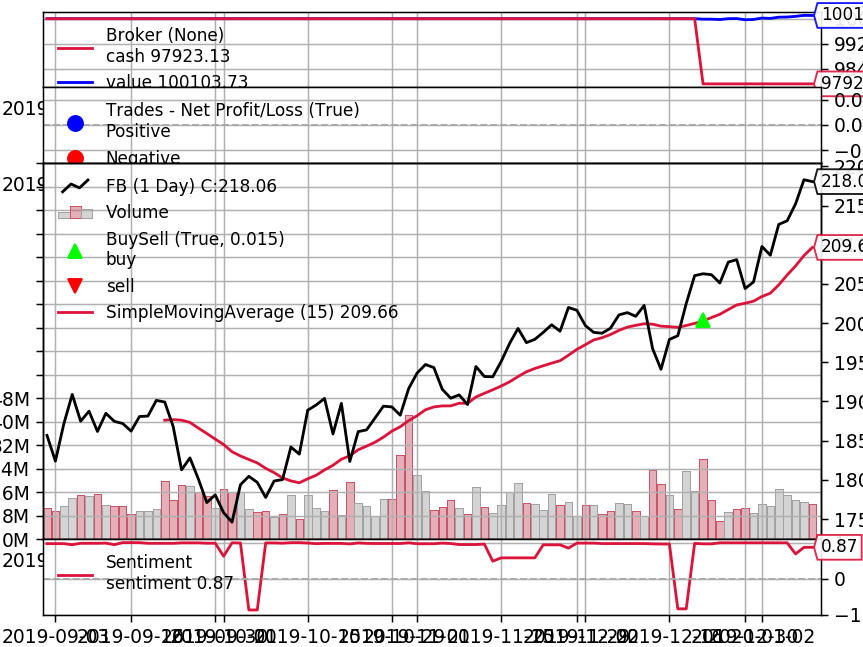

In [5]:
if __name__ == '__main__':
    # https://www.backtrader.com/docu/strategy/
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'FB',
        fromdate = earliest_date,
        todate = datetime.datetime(2020,1,13),
        reverse = False
    )
    
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()

From top to bottom panels: 
#### 1) Cash Value across time 
#### 2) Net Profit/Loss 
#### 3) Buy/Sell orders executed at Green/Red markers 
#### 4) Sentiment Score.

Final result: 100103.73 - 100000.0 = earn 103.73

http://datameetsmedia.com/vader-sentiment-analysis-explained/

https://www.backtrader.com/docu/quickstart/quickstart/

How is the Vader 'compound' polarity score calculated in Python NLTK?

https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Primarily, VADER sentiment analysis relies on a dictionary which maps lexical features to emotion intensities called sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

# Paper
https://arxiv.org/pdf/1010.3003&embedded=true